In [1]:
from pymongo import MongoClient
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import datetime
import seaborn
from sklearn import linear_model
import numpy as np

In [2]:
client = MongoClient('127.0.0.1', 3001)
db = client.meteor
images = list(db.facebook.find({}))

In [3]:
df = pd.DataFrame(images)
df = df.dropna(subset = ['normalized_log_likes'])
# drop data with missing username
df = df[df['user'] != 'profile.php']
df = df.set_index(pd.TimeSeries(df.timestamp))

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: FutureWarning: TimeSeries is deprecated. Please use Series


In [4]:
likes = np.zeros((len(df), 1))
responses = np.zeros((len(df), 2048))
categories = np.zeros((len(df), 1008))
facedata = np.zeros((len(df), 3))

for i in range(len(df)):
    likes[i, :] = df['normalized_log_likes'][i]
    responses[i, :] = df['inception_pool'][i]
    categories[i, :] = df['inception_classification'][i]

In [5]:
users = set(df['user'])
users = list(users)
user_hot = np.zeros((len(df), len(users)-1))

for i in range(len(df)):
    user_index = users.index(df['user'][i])
    if (user_index) > 0:
        user_hot[i, user_index-1] = 1

In [6]:
# # choose 100 random users to be the test set
# test_users = np.random.choice(len(users)-1, 100) + 1
# test_set = np.any(user_hot[:, test_users - 1], axis = 1)

# # choose 100 random users to be the validation set
# validation_users = np.array([v for v in (np.random.choice(len(users)-1, 100) + 1) if v not in test_users])
# validation_set = np.any(user_hot[:, validation_users - 1], axis = 1)

# training_users = np.logical_and(np.logical_not(test_set), np.logical_not(validation_set)
# training_responses = np.hstack((responses[training_set, :],user_hot[training_set, :]))
# training_likes = likes[training_set]

In [7]:
# test_responses = np.hstack((responses[test_set, :],0*user_hot[test_set, :]))
# test_likes = likes[test_set]

In [6]:
test_set = np.random.choice(len(responses), 2000, replace=False)
validation_set = np.array([v for v in np.random.choice(len(responses), 2130, replace=False) if v not in test_set])
training_set = [v for v in range(len(responses)) if v not in validation_set and v not in test_set]

X_train = responses[training_set]
y_train = np.ravel(likes[training_set])

In [7]:
from sklearn import svm

In [8]:
svr = svm.SVR(C = 0.1, epsilon = 0.35, kernel = 'rbf', cache_size=4000)
svr.fit(X_train[:10000], np.ravel(y_train[:10000]))
svr.score(responses[validation_set], likes[validation_set])

0.040589694869078263

In [24]:
svr = svm.SVR(C = 0.1, epsilon = 0.35, kernel = 'rbf', cache_size=4000)
svr.fit(X_train, np.ravel(y_train))
svr.score(responses[validation_set], likes[validation_set])

0.055483557218220736

In [25]:
svr.score(responses[test_set], likes[test_set])

0.041646708156635293

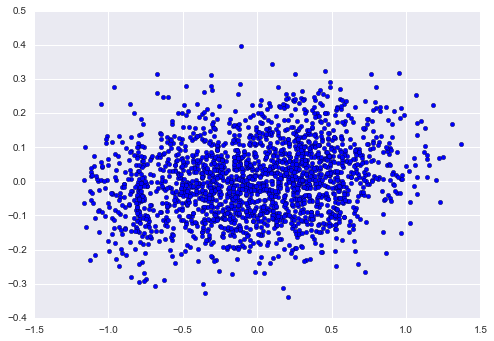

In [29]:
pred_likes = svr.predict(responses[test_set])

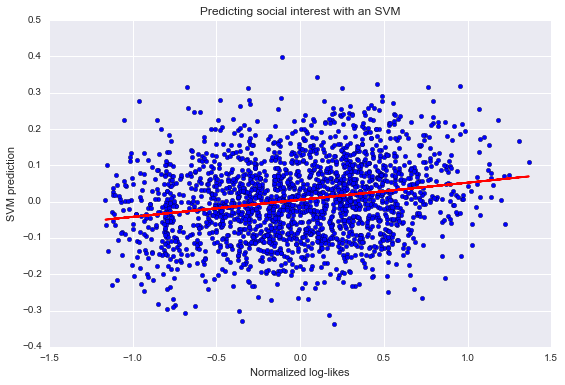

In [32]:
from sklearn import linear_model

lin = linear_model.LinearRegression()
lin.fit(likes[test_set], pred_likes)

plt.scatter(likes[test_set], pred_likes)
plt.plot(likes[test_set], likes[test_set] * lin.coef_ + lin.intercept_, color='red')
plt.xlabel('Normalized log-likes')
plt.ylabel('SVM prediction')
plt.title('Predicting social interest with an SVM')
plt.tight_layout()
plt.savefig('svm_prediction.png', dpi=300)

In [1]:
import pickle

In [2]:
lin

NameError: name 'lin' is not defined